# Training Iris dataset classification model on Multi-Layer Perceptron

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

In [98]:
iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1310)
X_train.shape, X_test.shape

((105, 4), (45, 4))

In [99]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# norm features and cvt to tensors
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train).float()

# create dataset and dataloader
train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(13)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [100]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x) # activation function
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x) # support for multiclass
        
        return x
    

In [101]:
input_size = X_train_norm.shape[1] # num of features
hidden_size = 16
output_size = len(np.unique(y_train)) # num of classes
 
model = Model(input_size,
              hidden_size,
              output_size)

learning_rate = 0.0005

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [102]:
# Now train the model

n_epochs = 200
# we're gonna draw learning curves so keep track of metrics
loss_hist = [0] * n_epochs
accuracy_hist = [0] * n_epochs

for epoch in range(n_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward() # backpropagate
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        # now select indexes of max score which match with the class number, and cmp with real Y
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

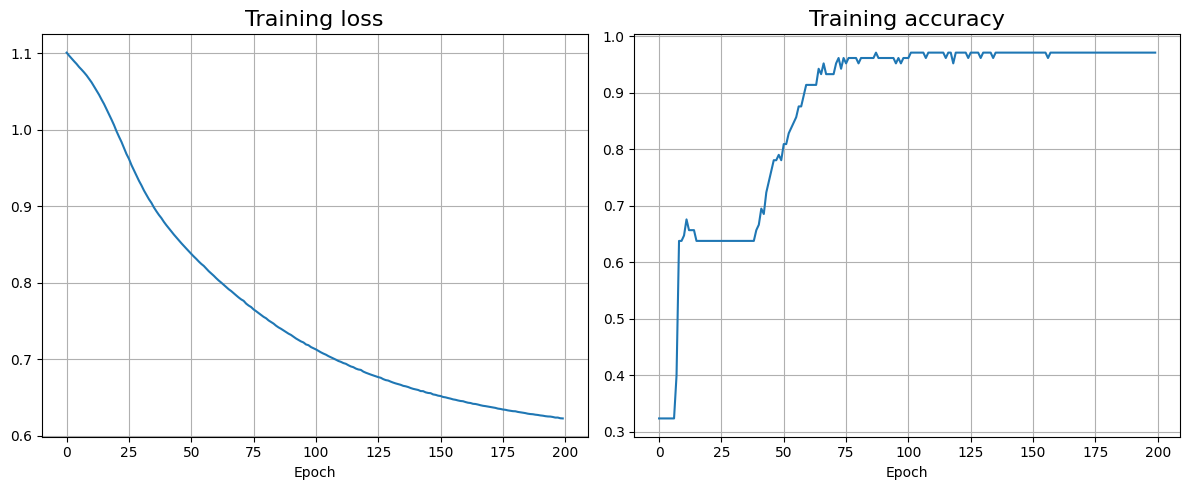

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].plot(loss_hist)
ax[0].set_title('Training loss', size=16)
ax[0].set_xlabel('Epoch')
ax[0].grid(True)

ax[1].plot(accuracy_hist)
ax[1].set_title('Training accuracy', size=16)
ax[1].set_xlabel('Epoch')
ax[1].grid(True)

plt.tight_layout()

## Evaluate on test set

In [104]:
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)

X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test).float()

pred_test = model(X_test_norm)

In [105]:
correct = (pred_test.argmax(dim=1) == y_test).float()
accuracy = correct.sum() / len(y_test)
print(f'Test Accuracy: {accuracy:0.4f}')

Test Accuracy: 0.9778
